**The purpose of this notebook is to examine the performance of neural network models and CNN with word embeddings in multi-class classifications using a small train dataset.**

In [123]:
'''data'''
import pandas as pd
import numpy as np
import re

'''plots'''
import matplotlib.pyplot as plt 

'''keras'''
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from keras.layers import Dropout,concatenate

from keras.layers.core import Reshape
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers

'''Gensim'''
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors


'''metrics'''
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split

## Import the data

In [50]:
train_raw=pd.read_csv("data/train.csv")

In [51]:
train_raw.shape

(159571, 8)

To test the benefits of using pre-trained word embeddings on problems where there is very little training data available I will only train on 900 samples. I will sample 300 comment_text from each the toxic, obscene, and insult class.  In doing so, I convert this problem from a multi-label classification problem with a large train dataset to a multi-class classification problem with a very small train dataset. 

In [52]:
''' This function get a subset of the full train/test data'''
def get_subset_data(df, size):
    df_toxic = df[(df.toxic==1) &
       (df.severe_toxic==0) & 
       (df.obscene==0) & 
       (df.threat==0) & 
       (df.insult==0) & 
       (df.identity_hate==0)]
    df_toxic = df_toxic.sample(size)

    df_obscene = df[(df.toxic==0) &
       (df.severe_toxic==0) & 
       (df.obscene==1) & 
       (df.threat==0) & 
       (df.insult==0) & 
       (df.identity_hate==0)]
    df_obscene = df_obscene.sample(size)

    df_insult = df[(df.toxic==0) &
       (df.severe_toxic==0) & 
       (df.obscene==0) & 
       (df.threat==0) & 
       (df.insult==1) & 
       (df.identity_hate==0)]
    df_insult= df_insult.sample(size)

    data = pd.concat([df_toxic, df_obscene, df_insult], axis=0)
    data = data.sample(size*3, random_state=10)
    data = data.reset_index(drop=True)

    data = data.drop(["severe_toxic","threat", "identity_hate"], axis=1)

    return data

In [53]:
train = get_subset_data(train_raw, 300)
train.shape

(900, 5)

**Repeat the same thing for the test dataset.  I will sample 40 samples from the 3 classes (toxic, obscene, insult) so the test dataset will have 120 samples.**

In [54]:
test_labels = pd.read_csv('data/test_labels.csv')
test_labels = test_labels[test_labels.toxic!=-1]
test_data = pd.read_csv('data/test.csv')
test_raw = pd.merge(test_data, test_labels, on="id", how="right")

In [55]:
test = get_subset_data(test_raw, 40)
test.shape

(120, 5)

In [56]:
# Get the texts from the train dataset
texts = train.comment_text
# Get the labels from the train dataset
labels = train.iloc[:,2:]

In [57]:
texts.shape, labels.shape

((900,), (900, 3))

## Process text
- Use the keras tokenizer to tokenize the text and remove non-alphanumeric symbols and take lowercase of the tokens.

In [58]:
max_words = 10000 # considers only the top 10000 words in the train dataset
maxlen = 100 # cut comments after 100 words

In [59]:
# init the keras tokenizer, configured to only take into account the 10000 most common words
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True)

In [60]:
tokenizer.fit_on_texts(texts) # builds the word index

In [61]:
sequences = tokenizer.texts_to_sequences(texts) # turn strings into lists of integer indices (one list per doc)

In [62]:
word_index = tokenizer.word_index # get the word index that the tokenizer computed

In [63]:
word_index;

In [64]:
print(f"Found {len(word_index)} unique tokens.")

Found 8448 unique tokens.


In [65]:
# Turn sequences-- lists of integers (word indices) into a 2D integer tensor of shape 
# (number of train observations, maxlen of each doc)
data = pad_sequences(sequences, maxlen= maxlen)

In [66]:
data

array([[   0,    0,    0, ..., 2374, 3645, 2375],
       [   0,    0,    0, ...,  733,    7,   33],
       [   0,    0,    0, ..., 1028, 1454, 1027],
       ...,
       [   0,    0,    0, ...,   77,  320, 8439],
       [   0,    0,    0, ...,   55,  177,   19],
       [8444, 8445,    5, ...,   23, 2064, 2373]])

In [67]:
# Convert labels to an array
labels = np.asarray(labels)

In [68]:
labels

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int64)

In [69]:
print(f"The shape of the data tensor is: {data.shape}")
print("")
print(f"The shape of the label tensor is: {labels.shape}")

The shape of the data tensor is: (900, 100)

The shape of the label tensor is: (900, 3)


In [70]:
data

array([[   0,    0,    0, ..., 2374, 3645, 2375],
       [   0,    0,    0, ...,  733,    7,   33],
       [   0,    0,    0, ..., 1028, 1454, 1027],
       ...,
       [   0,    0,    0, ...,   77,  320, 8439],
       [   0,    0,    0, ...,   55,  177,   19],
       [8444, 8445,    5, ...,   23, 2064, 2373]])

In [71]:
# Split the data into test and train set
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=10)

In [72]:
X_train.shape, X_val.shape, X_val.shape, y_val.shape

((630, 100), (270, 100), (270, 100), (270, 3))

## Load the word2vec pre-trained word embeddings

In [73]:
%%time 
# Load KeyedVectors for the Google News word embeddings
# Contains 3 million 300-D word embeddings trained from 100 billion words

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
# The vectors is loaded from an existing file on disk in the original Google’s word2vec C format as 
#a KeyedVectors instance
word_vectors = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin.gz', 
                                                            binary=True) # C bin format

Wall time: 3min 14s


**Build an Embedding Matrix that I can load to the Embedding layer** 
- Embedding layer: a dictionary that mpas integer word indices to dense vector representations, it takes a word index, looks up the index in an internal dictionary, and outputs its associated word vectors.
- Embedding matrix is a matrix of shape (max_words= 10000, embedding dim = 300).  Each entry i contains a 100-D word vector of the word of index i in the reference word index (built during tokenization).  Note that Index 0 is a placeholder.

In [74]:
embedding_dim = 300  # dimension of the word embeddings (word vectors)
# I will use vocabulary_size to determine the size of the embedding matrix (number of rows)
# +1 since index 0 of the embedding matrix is only a placeholder
vocabulary_size=min(len(word_index)+1,(max_words)) 

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
embedding_matrix.shape

(8449, 300)

In [75]:
word_index.items(); # a list of tuples of (key, value)

In [76]:
%%time 
for word, i in word_index.items():
    if i >= max_words: # only get at most 8747 word vectors
        continue
    try:
        embedding_vector = word_vectors[word] # get the word embedding from word2vec
        embedding_matrix[i] = embedding_vector # fill the ith row of the embedding matrix with the word vector
    except KeyError:  # word not found in word2vec will be zeros
        embedding_matrix[i] = np.zeros(embedding_dim)

Wall time: 505 ms


## Modelling
- Armed with the embedding matrix, I will load it into my embedding layer as its weights (the first layer in my network).
- Since the embedding layer uses the weights from the embedding matrix (comes from the pre-trained word2vec), I don't need to update them with backpropogation during training.  I want to "keep" my already-learnt features. Thus, I will "freeze" the embedding layer.
- I will train two fully-connected layers on top of the emebdding layer for multi-class classification (use this as baseline).  The activation function for the last layer should be softmax, and I should use categorical_crossentropy as loss function.
- I will also train a CNN for multi-class classification.

In [77]:
# init the network
model = Sequential()
# embedding layer, I specify the number of possible tokens, the dim of word vectors, 
# and the length of each doc (sequence)
# the output of embedding layer have shape (samples, maxlen, embedding dim) = (900, 100, 300)
model.add(Embedding(vocabulary_size, embedding_dim, input_length = maxlen))  
# I flatten the 3-D tensor into a 2D tensor of shape (samples, maxlen*300) = (900, 30000)
# Each comment/doc is represented by a single 1-D tensor-- each word in the input sequence is treated separately 
# with no inter-wird relationships and sentence structure
model.add(Flatten()) 
model.add(Dense(32, activation='relu')) # add a hidden layer with 32 neurons
# use softmax as activation function for the last layer for multi-class classification (3 classes)
model.add(Dense(3, activation= 'softmax')) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          2534700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 3,494,831
Trainable params: 3,494,831
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Load the word2vec pre-trained word vectors to the embedding layer.
model.layers[0].set_weights([embedding_matrix])  # embedding layer is the first layer in the network
model.layers[0].trainable= False # freeze the embedding layer

In [79]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Use early stopping
# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(X_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (X_val, y_val))
                   #callbacks=callbacks)

Train on 630 samples, validate on 270 samples
Epoch 1/10
630/630 [==============================] - 4s 7ms/step - loss: 1.1188 - accuracy: 0.3683 - val_loss: 1.0902 - val_accuracy: 0.3852
Epoch 2/10
630/630 [==============================] - 1s 858us/step - loss: 0.6510 - accuracy: 0.7968 - val_loss: 1.1401 - val_accuracy: 0.3407
Epoch 3/10
630/630 [==============================] - 1s 910us/step - loss: 0.3327 - accuracy: 0.9429 - val_loss: 1.2983 - val_accuracy: 0.3704
Epoch 4/10
630/630 [==============================] - 1s 841us/step - loss: 0.1547 - accuracy: 0.9905 - val_loss: 1.2349 - val_accuracy: 0.4074
Epoch 5/10
630/630 [==============================] - 1s 822us/step - loss: 0.0819 - accuracy: 0.9968 - val_loss: 1.2946 - val_accuracy: 0.3926
Epoch 6/10
630/630 [==============================] - 1s 833us/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 1.5256 - val_accuracy: 0.3852
Epoch 7/10
630/630 [==============================] - 1s 839us/step - loss: 0.0215 - accurac

In [80]:
model.evaluate(X_val,y_val) 

270/270 [==============================] - 0s 155us/step


[1.8760740368454545, 0.4000000059604645]

## Thoughts
- Pretty poor performance, but this is to be expected due to the small number of training eamples-- the network will quickly starts overfitting (as seen in plots below).
- In addition, my network only consists of several dense layers on top of the embedding layer. The model will not consider inter-word relations and sentence structure.

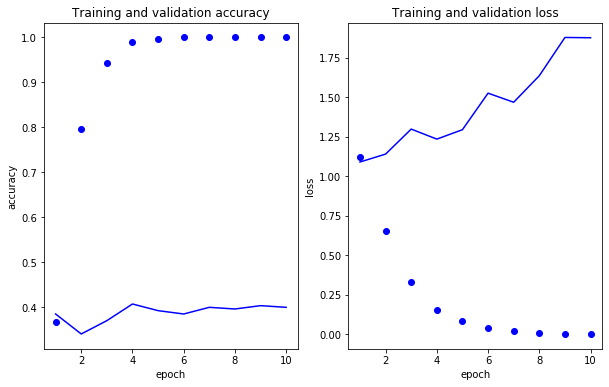

In [81]:
# Plot model performance over epochs
train_acc = history.history["accuracy"] # train accuracy of each of the 10 train epoch
validation_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(1,len(train_acc)+1,1)

fig, axes = plt.subplots(1,2, figsize=(10,6))
axes[0].plot(epochs, train_acc, 'bo', label = "Training acc")
axes[0].plot(epochs,validation_acc, 'b', label = "Validation acc")
axes[0].set_title("Training and validation accuracy")
axes[0].set_ylabel("accuracy")
axes[0].set_xlabel("epoch")


axes[1].plot(epochs, train_loss, 'bo', label = "Training loss")
axes[1].plot(epochs,validation_loss, 'b', label = "Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].set_ylabel("loss")
axes[1].set_xlabel("epoch")

plt.show()

**The validation accuracy basically stalls at 0.4-- it's hard to get good performance with a very small sample!**

**Check performance of model on holdout (test) dataset**

In [82]:
# Get the texts from the test dataset
test_texts = test.comment_text
# Get the labels from the test dataset
test_labels = test.iloc[:,2:]

In [83]:
test_sequences = tokenizer.texts_to_sequences(test_texts) # turn strings into lists of integer indices (one list per doc)

In [84]:
# Turn sequences-- lists of integers (word indices) into a 2D integer tensor of shape 
# (number of test observations, maxlen of each doc)
X_test = pad_sequences(test_sequences, maxlen= maxlen)
y_test = np.asarray(test_labels)

In [85]:
X_test.shape, y_test.shape

((120, 100), (120, 3))

In [86]:
model.evaluate(X_test,y_test) # 0.4666 accuracy

120/120 [==============================] - 0s 192us/step


[2.0687135537465413, 0.375]

## Text classifications with convnets
- https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/
- Convnet convolute across the embedding matrix and extracting features from "local" patches of data
- As per Kim Yoon's "Convolutional Neural Networks for Sentence Classification", we will only use conv layer to extract features using filter_size 1,2 and 3.
- The size of the filter is (filter_size, embeding_dim). If filter_size = 1, I will only extract unigram features; and if filter_size=2, I will extract bigrams features.
- I will use 1-max pooling to get the max value of the feature map of each filter.
- Thus, if I have 6 filters, I will get a 6x1 vector after the 1-max pooling.
- Finally, I will have a fully connected layer and softmax layer.

**Settings**

In [87]:
sequence_length = X_train.shape[1] # number of words in each doc
filter_sizes = [1,2,3] # filter size for conv layer 1, and for conv layer 2  (consider unigrams and bigrams)
num_filters = 50 # number of filters for each conv layer
drop = 0.4  # probability of dropping neurons

In [88]:
embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

**Build model**

In [93]:
# The input to the embeddings layer for each doc is bascially an array of word index of length "sequence_length",
# the length of each doc
inputs = Input(shape=(sequence_length,))
# Emedding layer:
    # Input: word index of shape (100,)
    # output: a 3D tensor of shape (samples, sequence_length, embedding_dim) = (samples, 100, 300)
embedding = embedding_layer(inputs)
# reshape the output of the embedding layer to shape (100, 300, 1 )
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)  

# conv layer 1 (use filter window size 1: extract unigrams)
# input is the "reshaped" embedding matrix
conv_0 = Conv2D(num_filters, # number of filters (100) 
                (filter_sizes[0], embedding_dim), # shape of the filter (1,100)
                activation='relu', # activation function
                # Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. 
                # These penalties are summed into the loss function that the network optimizes.
                kernel_regularizer=regularizers.l2(0.01))(reshape)


# conv layer 2 (use filter window size 2: extract bigrams)
# input is the "reshaped" embedding matrix
conv_1 = Conv2D(num_filters, 
                (filter_sizes[1], embedding_dim),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(reshape)

# conv layer 2 (use filter window size 3: extract trigrams)
# input is the "reshaped" embedding matrix
conv_2 = Conv2D(num_filters, 
                (filter_sizes[2], embedding_dim),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(reshape)


# Apply max pooling to the activation maps (100 of them) for EACH conv layer
# sequence_length - filter_sizes[0] + 1 is the length of Each feature map
maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0) # size of 1x100
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

# I get a feature from each of the 1-max pooling layer, so I have 3 features in total
# I concat the features to get a 3 feature vector of size 3x100
merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1) 
flatten = Flatten()(merged_tensor) 
# reshape_1 = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(20)(dropout)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(conc)

In [94]:
# this creates a model class with takes a Keras.Input object and the outputs of the model as argument
model = Model(inputs, output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     2534700     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 100, 300, 1)  0           embedding_2[2][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 100, 1, 50)   15050       reshape_3[0][0]                  
____________________________________________________________________________________________

**Train model**

In [95]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Use early stopping
# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(X_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (X_val, y_val))

Train on 630 samples, validate on 270 samples
Epoch 1/10
630/630 [==============================] - 5s 8ms/step - loss: 1.2068 - accuracy: 0.4000 - val_loss: 1.1328 - val_accuracy: 0.5519
Epoch 2/10
630/630 [==============================] - 1s 2ms/step - loss: 1.0578 - accuracy: 0.5730 - val_loss: 1.0830 - val_accuracy: 0.5519
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 0.9579 - accuracy: 0.6794 - val_loss: 1.0646 - val_accuracy: 0.5370
Epoch 4/10
630/630 [==============================] - 1s 2ms/step - loss: 0.8811 - accuracy: 0.7333 - val_loss: 1.0858 - val_accuracy: 0.5333
Epoch 5/10
630/630 [==============================] - 2s 3ms/step - loss: 0.8312 - accuracy: 0.7921 - val_loss: 1.0550 - val_accuracy: 0.6037
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 0.7543 - accuracy: 0.8063 - val_loss: 1.1103 - val_accuracy: 0.5407
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 0.7033 - accuracy: 0.8476 - 

In [96]:
model.evaluate(X_test,y_test) # 0.558 accuracy

120/120 [==============================] - 0s 1ms/step


[1.0896392663319905, 0.625]

## Try 1-D convnet with a slightly different structure

In [97]:
# init the network
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim, input_length = maxlen))  
model.add(Conv1D(32,7,activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01))) # 32 filters, each with filter size of 7
model.add(MaxPooling1D(5)) # window size of 5, get max number in each window
model.add(Conv1D(32,7,activation='relu',
                kernel_regularizer=regularizers.l2(0.01))) # 32 filters, each with filter size of 7
model.add(GlobalMaxPooling1D()) # get max number of each filter
# use softmax as activation function for the last layer for multi-class classification (3 classes)
model.add(Dense(3, activation= 'softmax')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          2534700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 32)            67232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 2,609,231
Trainable params: 2,609,231
Non-trainable params: 0
____________________________________________

In [98]:
# Load the word2vec pre-trained word vectors to the embedding layer.
model.layers[0].set_weights([embedding_matrix])  # embedding layer is the first layer in the network
model.layers[0].trainable= False # freeze the embedding layer

In [99]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(X_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (X_val, y_val))

Train on 630 samples, validate on 270 samples
Epoch 1/10
630/630 [==============================] - 3s 5ms/step - loss: 1.8601 - accuracy: 0.3968 - val_loss: 1.7333 - val_accuracy: 0.4185
Epoch 2/10
630/630 [==============================] - 1s 2ms/step - loss: 1.5940 - accuracy: 0.5190 - val_loss: 1.5871 - val_accuracy: 0.4185
Epoch 3/10
630/630 [==============================] - 1s 2ms/step - loss: 1.4247 - accuracy: 0.6159 - val_loss: 1.5062 - val_accuracy: 0.4000
Epoch 4/10
630/630 [==============================] - 1s 1ms/step - loss: 1.3259 - accuracy: 0.6159 - val_loss: 1.4493 - val_accuracy: 0.4074
Epoch 5/10
630/630 [==============================] - 1s 2ms/step - loss: 1.2198 - accuracy: 0.6619 - val_loss: 1.4061 - val_accuracy: 0.4000
Epoch 6/10
630/630 [==============================] - 1s 2ms/step - loss: 1.1610 - accuracy: 0.6492 - val_loss: 1.5058 - val_accuracy: 0.3407
Epoch 7/10
630/630 [==============================] - 1s 2ms/step - loss: 1.0927 - accuracy: 0.7206 - 

In [100]:
model.evaluate(X_test,y_test) # 0.47 accuracy  

120/120 [==============================] - 0s 383us/step


[1.4490847667058309, 0.38333332538604736]

**In sum, it is tough to improve the performance of text classification models with small datasets, even with CNN and regularization to alleivate overfitting.**

## Let's try to increase the sample size to 50000
- We will also increase the complexity of the problem-- classify comments into 6 non-exclusive classes

In [102]:
train_raw.shape, test_raw.shape

((159571, 8), (63978, 8))

In [104]:
train = train_raw.sample(50000) # take 50000 samples

In [105]:
test = test_raw

In [106]:
# Get the texts from the train dataset
texts = train.comment_text
# Get the labels from the train dataset
labels = train.iloc[:,2:]

In [108]:
texts.shape, labels.shape

((50000,), (50000, 6))

In [110]:
max_words = 10000 # considers only the top 10000 words in the train dataset
maxlen = 100 # cut comments after 100 words

# init the keras tokenizer, configured to only take into account the 10000 most common words
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True)

In [111]:
tokenizer.fit_on_texts(texts) # builds the word index
sequences = tokenizer.texts_to_sequences(texts) # turn strings into lists of integer indices (one list per doc)
word_index = tokenizer.word_index # get the word index that the tokenizer computed
print(f"Found {len(word_index)} unique tokens.")

Found 102251 unique tokens.


In [112]:
# Turn sequences-- lists of integers (word indices) into a 2D integer tensor of shape 
# (number of train observations, maxlen of each doc)
data = pad_sequences(sequences, maxlen= maxlen)

In [113]:
# Convert labels to an array
labels = np.asarray(labels)

In [119]:
print(f"The shape of the data tensor is: {data.shape}")
print("")
print(f"The shape of the label tensor is: {labels.shape}")

The shape of the data tensor is: (50000, 100)

The shape of the label tensor is: (50000, 6)


In [128]:
# Split the data into test and train set
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                  labels, 
                                                  test_size=0.3, 
                                                  shuffle= True,
                                                  random_state=10)

**Build embedding matrix**

In [129]:
embedding_dim = 300  # dimension of the word embeddings (word vectors)
# I will use vocabulary_size to determine the size of the embedding matrix (number of rows)
# +1 since index 0 of the embedding matrix is only a placeholder
vocabulary_size=min(len(word_index)+1,(max_words)) 

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
embedding_matrix.shape

(10000, 300)

In [130]:
%%time 
for word, i in word_index.items():
    if i >= max_words: # only get at most 8747 word vectors
        continue
    try:
        embedding_vector = word_vectors[word] # get the word embedding from word2vec
        embedding_matrix[i] = embedding_vector # fill the ith row of the embedding matrix with the word vector
    except KeyError:  # word not found in word2vec will be zeros
        embedding_matrix[i] = np.zeros(embedding_dim)

Wall time: 17.3 s


**Try 1-D conv net**

In [138]:
# init the network
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_dim, input_length = maxlen))  
model.add(Conv1D(32,7,activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01))) # 32 filters, each with filter size of 7
model.add(MaxPooling1D(5)) # window size of 5, get max number in each window
model.add(Conv1D(32,7,activation='relu',
                kernel_regularizer=regularizers.l2(0.01))) # 32 filters, each with filter size of 7
model.add(GlobalMaxPooling1D()) # get max number of each filter
# use softmax as activation function for the last layer for multi-class classification (3 classes)
model.add(Dense(6, activation= 'sigmoid')) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 94, 32)            67232     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 12, 32)            7200      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 3,074,630
Trainable params: 3,074,630
Non-trainable params: 0
____________________________________________

In [139]:
# Load the word2vec pre-trained word vectors to the embedding layer.
model.layers[0].set_weights([embedding_matrix])  # embedding layer is the first layer in the network
model.layers[0].trainable= False # freeze the embedding layer

In [141]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Use early stopping
callbacks = [EarlyStopping(monitor='val_loss')]


history = model.fit(X_train, y_train,
                   epochs = 10,
                   batch_size = 128,
                   validation_data = (X_val, y_val),
                   callbacks = callbacks)

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 43s 1ms/step - loss: 0.1413 - accuracy: 0.9629 - val_loss: 0.1440 - val_accuracy: 0.9624
Epoch 2/10
35000/35000 [==============================] - 42s 1ms/step - loss: 0.1401 - accuracy: 0.9629 - val_loss: 0.1395 - val_accuracy: 0.9624
Epoch 3/10
35000/35000 [==============================] - 42s 1ms/step - loss: 0.1389 - accuracy: 0.9629 - val_loss: 0.1400 - val_accuracy: 0.9624
Wall time: 2min 7s


In [142]:
# Get the texts from the test dataset
test_texts = test.comment_text
# Get the labels from the test dataset
test_labels = test.iloc[:,2:]

In [143]:
test_sequences = tokenizer.texts_to_sequences(test_texts) # turn strings into lists of integer indices (one list per doc)

# Turn sequences-- lists of integers (word indices) into a 2D integer tensor of shape 
# (number of test observations, maxlen of each doc)
X_test = pad_sequences(test_sequences, maxlen= maxlen)
y_test = np.asarray(test_labels)

In [144]:
model.evaluate(X_test,y_test)

63978/63978 [==============================] - 24s 377us/step


[0.14127448016294986, 0.962231457233429]

**Thoughts**
- Sure enough, by increasing the sample size, even with a relatively simple conv1D model, the test accuracy (on test data) is a lot higher.